# Feedback Prize EDA

Hey there NLP fans, I didn't expect another NLP competition right now, how about you? Let's take a look to see what this one is about :) We'll start with looking at the data, and then look at all the info from the organizers - this sequence works best for me :) 

In [1]:
import pandas as pd
import os
from pathlib import Path
import spacy
from spacy import displacy
from pylab import cm, matplotlib

### Training Data

Looks like we have a bunch of text files and a separate `train.csv` with labels. Let's start by looking at the csv. We get reference to the text files, and then multiple lines per text file with spans indicating a specific **discourse type**. Let's also see what are the unique types of discourse below.

In [2]:
train = pd.read_csv('../input/feedback-prize-2021/train.csv')
train.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [3]:
train.discourse_type.unique().tolist()

['Lead',
 'Position',
 'Evidence',
 'Claim',
 'Concluding Statement',
 'Counterclaim',
 'Rebuttal']

### Visualize with `displacy`

I think it will work best if we can overlay the spans from the csv file onto the text files. Spacy has a great visualizer for this: `displacy`. Let's use it to see what a single example looks like!

In [4]:
path = Path('../input/feedback-prize-2021/train')

colors = {
            'Lead': '#8000ff',
            'Position': '#2b7ff6',
            'Evidence': '#2adddd',
            'Claim': '#80ffb4',
            'Concluding Statement': 'd4dd80',
            'Counterclaim': '#ff8042',
            'Rebuttal': '#ff0000'
         }

def visualize(example):
    ents = []
    for i, row in train[train['id'] == example].iterrows():
        ents.append({
                        'start': int(row['discourse_start']), 
                         'end': int(row['discourse_end']), 
                         'label': row['discourse_type']
                    })

    with open(path/f'{example}.txt', 'r') as file: data = file.read()

    doc2 = {
        "text": data,
        "ents": ents,
        "title": example
    }

    options = {"ents": train.discourse_type.unique().tolist(), "colors": colors}
    displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True)


In [5]:
examples = train['id'].sample(n=5, random_state=42).values.tolist()

for ex in examples:
    visualize(ex)
    print('\n')

### Insights

Ok - this looks interesting!: 
- For some examples, the entire text is densely split into spans of different categories. In some other examples, the annotators omit some words and the splits look very subjective. It's an indicator that annotations may be noisy. 
- Order seems to be important: start with the lead, mix claims and evidence, finish with concluding statement. We may need to incorporate this into our models. 
- There may be 2 spans of the same class next to each other - it will be important to separate them!

### Text length

Another important data point is the length of texts - would they fit into a model like `roberta`? Let's check!

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors


0.44081632653061226


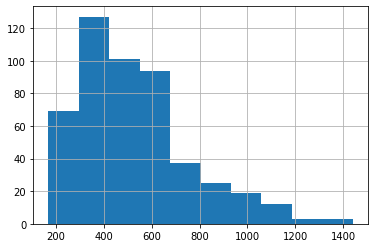

In [7]:
texts = []

ids = train.sample(n=500)['id'].unique().tolist()
len(ids)

for example in ids:
    with open(path/f'{example}.txt', 'r') as file: data = file.read()
    texts.append({
        'text': data,
        'n_tokens': len(tokenizer(data)['input_ids'])
    })
     
df = pd.DataFrame(texts)

print(len(df[df.n_tokens > 512])/len(df))

df.n_tokens.hist();

**Important** More than half texts exceed typical max length of 512 tokens, so we'll likely need to apply some sliding window or other chunking approach to the data!

### Number of spans per text

Let's also see how many spans there are per text. Let's also visualize texts with the fewest and the most spans. }

Min: 1
Max: 26


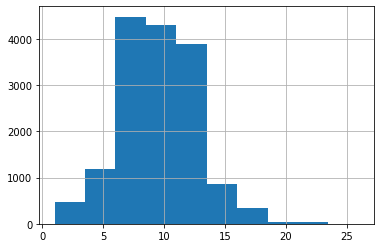

In [8]:
dist = train.groupby('id')['discourse_type'].apply(lambda x: len(list(x)))

print(f'Min: {dist.min()}')
print(f'Max: {dist.max()}')

dist.hist();

In [9]:
dist.sort_values()

id
FFFF80B8CC2F     1
FC7A3692794B     1
547C43CF3291     1
54B7666CDA35     1
655EC70088AA     1
                ..
EDC567D40996    24
7C9C2DF37B67    25
A02E1D0BEACF    25
71259B3EA87F    26
149E8C278863    26
Name: discourse_type, Length: 15594, dtype: int64

In [10]:
visualize('FFFF80B8CC2F')
visualize('FC7A3692794B')
visualize('149E8C278863')
visualize('71259B3EA87F')

### Test

In [11]:
sub = pd.read_csv('../input/feedback-prize-2021/sample_submission.csv')
sub.head()

,id,class,predictionstring
0,18409261F5C2,NaN,NaN
1,D46BCB48440A,NaN,NaN
2,0FB0700DAF44,NaN,NaN
3,D72CB1C11673,NaN,NaN
4,DF920E0A7337,NaN,NaN


Ok, so it looks like for test we also get files in a similar format, and we need to predict class and prediction string. I guess it's now time to look at the information provided by the host to understand this better :) 

> The word indices are calculated by using Python's .split() function and taking the indices in the resulting list. The two overlaps are calculated by taking the set() of each list of indices in a ground truth / prediction pair and calculating the intersection between the two sets divided by the length of each set.

I think that means we need to provide the indices of words that are in our predicted span in the `predictionstring` field.



## Baseline

This is an interesting task! It can be approached in several ways:
1. Split texts, for example by sentence, and then classify each sentence. 
2. NER: classify individual tokens (words)
3. Question answering: use discourse types as questions, and predict answer spans

Each approach has some downsides or complexities... I think we have enough data to start building a baseline. I'll go ahead and start to prepare one in a separate notebook, and come back to this EDA later. 

### I will smile for every upvote :)